<a href="https://colab.research.google.com/github/Jamess200/BirdnetProject/blob/main/Files/scripts/Main_AI_Human.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title **<------------ Part 1 ------------>**

In [ ]:
#@title **Audio Processing and CSV Creation - BirdNET Analysis Notebook**
# This notebook guides you through analysing bird audio recordings using BirdNET.

In [15]:
#@title **Step 1: Install & Import Required Libraries**
# Install PyDrive to download files from Google Drive, and other packages for processing.
!pip install PyDrive birdnetlib tflite-runtime resampy ffmpeg pygbif mplcursors

# Import necessary libraries for BirdNET
import resampy
import birdnetlib
import tflite_runtime
import ffmpeg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import os
import re
from google.colab import drive
from google.colab import files
from sklearn.metrics import confusion_matrix, classification_report
from birdnetlib import Recording
from birdnetlib.analyzer import Analyzer
from datetime import datetime
from pygbif import occurrences
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [11]:
#@title **Step 2: Authenticate and Create PyDrive Client**
# This step authenticates with Google to access the shared folder on Google Drive.

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print("Authentication successful. You can now access files from the shared Google Drive folder.")

Authentication successful. You can now access files from the shared Google Drive folder.


In [24]:
#@title **Step 3: Clone the GitHub Repository**
# This step clones the required GitHub repository into the Colab environment.

# Define the path where the repository will be cloned
repo_path = '/content/BirdnetProject'

# Check if the repository already exists
if not os.path.exists(repo_path):
    # Clone the repository if it doesn't exist
    !git clone https://github.com/Jamess200/BirdnetProject
else:
    # If the repository exists, pull the latest changes
    os.chdir(repo_path)
    !git pull

# Verify cloned repository
print("Repository contents:")
!ls /content/BirdnetProject

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 7 (delta 3), reused 7 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 15.22 KiB | 974.00 KiB/s, done.
From https://github.com/Jamess200/BirdnetProject
   bdf5d17..c8e7f84  main       -> origin/main
Updating bdf5d17..c8e7f84
Fast-forward
 Files/data/xlsx_data/Drafts/HAU_IOC_Joined.xlsx | Bin 18280 -> 15777 bytes
 1 file changed, 0 insertions(+), 0 deletions(-)
Repository contents:
Files  HAU_IOC_Joined.xlsx  README.md


In [ ]:
#@title **Step 4: Define Helper Functions**
# These functions help to download the test audio file from my Google Drive folder to a local directory and list files.

def download_files_from_drive(folder_id, destination):
    """
    Download all files from a Google Drive folder to a local directory.

    :param folder_id: str, The ID of the Google Drive folder
    :param destination: str, The local directory to save the files
    """
    # List all files in the shared folder
    file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

    # Create a directory to store the downloaded audio files
    os.makedirs(destination, exist_ok=True)

    # Download each file to the local directory
    for file in file_list:
        file_id = file['id']
        file_name = file['title']
        file_path = os.path.join(destination, file_name)
        print(f"Downloading {file_name}...")
        downloaded_file = drive.CreateFile({'id': file_id})
        downloaded_file.GetContentFile(file_path)
    print("All files downloaded successfully!")

def list_files_in_directory(directory):
    """
    List all files in a directory and print their names.

    :param directory: str, The directory to list files
    """
    file_names = os.listdir(directory)
    print(f"Files in {directory}:")
    for file_name in file_names:
        print(file_name)
    return file_names

In [ ]:
#@title **Step 5: Download Audio Files from Google Drive**
# This step will download all audio files from the shared Google Drive folder to the local directory.

# Replace the folder ID with your shared folder's ID
folder_id = '1PAkwwWpQY5Y8vgvkmVYm5Z_oKBVfr3e_'  # Update this with your folder ID
dataDir = '/content/audio_files'

# Download files from Google Drive
download_files_from_drive(folder_id, dataDir)

# List all files in the directory to verify download
file_names = list_files_in_directory(dataDir)

All files downloaded successfully!
Files in /content/audio_files:
XC3_20210404_054400.mp3


In [ ]:

#@title **Step 6: Initialise BirdNET Analyzer and Process Audio Files**
# This step initialises the BirdNET-Analyzer model and processes the downloaded audio files.
# Initialise BirdNET-Analyzer model
analyzer = Analyzer()

# Define the coordinates and date for the recordings
coordinates = [51.7813, -2.5745]  # Replace with your coordinates (Latitude, Longitude)
recording_date = datetime(year=2021, month=4, day=4)

# Analyse Audio Files and Store Results
results = {}

for file_name in file_names:
    try:
        file_path = os.path.join(dataDir, file_name)

        # Skip directories
        if os.path.isdir(file_path):
            continue

        # Skip non-audio files
        if not file_name.lower().endswith(('.wav', '.mp3', '.flac')):
            print(f"Skipping non-audio file: {file_name}")
            continue

        # Initialise a Recording object
        recording = Recording(
            analyzer,
            file_path,  # path to the recording file
            lat=coordinates[0],  # latitude of the recording location
            lon=coordinates[1],  # longitude of the recording location
            date=recording_date,  # the date of the recording
            min_conf=0.1,  # Set Minimum Confidence
        )

        # Analyze the recording
        recording.analyze()

        # Store the results
        results[file_name] = recording.detections

    except Exception as e:
        print(f"Error processing {file_name}: {e}")

Labels loaded.
load model True
Model loaded.
Labels loaded.
load_species_list_model
Meta model loaded.
read_audio_data
read_audio_data: complete, read  1464 chunks.
analyze_recording XC3_20210404_054400.mp3
recording has lon/lat
set_predicted_species_list_from_position
return_predicted_species_list
13
141 species loaded.


In [ ]:
#@title **Step 7: Convert Results to DataFrame and Save as CSV**
# Flatten the results dictionary and convert it to a DataFrame. Save the DataFrame as a CSV file.

flattened_data = []
for filename, records in results.items():
    for record in records:
        record['filename'] = filename
        flattened_data.append(record)

# Convert the flattened data to a DataFrame
df = pd.DataFrame(flattened_data)

# Define the path to save the CSV file
csv_file_path = '/content/BirdnetProject/Files/data/CSV_data/XC/XC3_1_20210404_054400.csv'
os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

# Save the DataFrame to a CSV file
df.to_csv(csv_file_path, index=False)

print(f"Results have been successfully converted to CSV and saved to {csv_file_path}")


Results have been successfully converted to CSV and saved to /content/BirdnetProject/Files/data/CSV_data/XC/XC3_1_20210404_054400.csv


In [ ]:
#@title **Step 8: Load and Verify CSV Data**
# Load the saved CSV file into a DataFrame to verify the contents

# Load the CSV file
df = pd.read_csv(csv_file_path)

# Print the first few rows of the DataFrame to verify the data
print(df.head())

            common_name      scientific_name  start_time  end_time  \
0        European Robin   Erithacus rubecula       195.0     198.0   
1             Goldcrest      Regulus regulus       273.0     276.0   
2      Common Firecrest  Regulus ignicapilla       423.0     426.0   
3  Eurasian Treecreeper   Certhia familiaris       447.0     450.0   
4    Common Wood-Pigeon     Columba palumbus       555.0     558.0   

   confidence                                    label  \
0    0.103502        Erithacus rubecula_European Robin   
1    0.175837                Regulus regulus_Goldcrest   
2    0.103631     Regulus ignicapilla_Common Firecrest   
3    0.271523  Certhia familiaris_Eurasian Treecreeper   
4    0.110816      Columba palumbus_Common Wood-Pigeon   

                  filename  
0  XC3_20210404_054400.mp3  
1  XC3_20210404_054400.mp3  
2  XC3_20210404_054400.mp3  
3  XC3_20210404_054400.mp3  
4  XC3_20210404_054400.mp3  


In [ ]:
#@title **Step 9: Save CSV File to Desired Location**
# This step allows users to save the CSV file to their desired location.

# Ask the user where they want to save the CSV file
save_option = input("Where would you like to save the CSV file? Enter 'local' to download to your device or 'drive' to save to Google Drive: ")

if save_option.lower() == 'drive':
    # Mount Google Drive
    drive.mount('/content/drive')
    drive_csv_path = input("Enter the path in your Google Drive where you want to save the CSV file (e.g., /content/drive/MyDrive/BirdnetProject/Files/data/CSV_data/): ")
    drive_csv_path = os.path.join(drive_csv_path, os.path.basename(csv_file_path))
    # Copy the file to Google Drive
    !cp {csv_file_path} {drive_csv_path}
    print(f"CSV file saved to your Google Drive at {drive_csv_path}")
elif save_option.lower() == 'local':
    # Download the file to the user's local device
    files.download(csv_file_path)
    print("CSV file downloaded to your local device.")
else:
    print("Invalid option. Please enter 'local' or 'drive'.")

Where would you like to save the CSV file? Enter 'local' to download to your device or 'drive' to save to Google Drive: local


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV file downloaded to your local device.


In [ ]:
#@title **<------------ Part 2 ------------>**

In [ ]:
#@title **Creating Merged Dataframe Files**

In [ ]:
#@title **Step 1: Change Working Directory**
# Change working directory to defined path
os.chdir('/content/drive/MyDrive/BirdnetProject/Files/data/CSV_data/XC')

# Verify working directory
print(os.getcwd())

/content/drive/MyDrive/BirdnetProject/Files/data/CSV_data/XC


In [ ]:
#@title **Step 2: Create Merged Dataframe File For All Transects**

# Read in the CSV files
df_XC1 = pd.read_csv('XC1_25_20230615_180000.csv')
df_XC2 = pd.read_csv('XC2_25_20200530_171400.csv')
df_XC3 = pd.read_csv('XC3_25_20210404_054400.csv')

# Add a column to each dataframe to indicate the transect source
df_XC1['transect'] = 1
df_XC2['transect'] = 2
df_XC3['transect'] = 3

# Function to extract date and hour from the filename
def extract_datetime(filename):
    date_str = filename.split('_')[1]
    time_str = filename.split('_')[2].split('.')[0]
    datetime_str = date_str + ' ' + time_str
    datetime = pd.to_datetime(datetime_str, format='%Y%m%d %H%M%S')
    return datetime

# Apply the function to create a new datetime column
df_XC1['datetime'] = df_XC1['filename'].apply(extract_datetime)
df_XC2['datetime'] = df_XC2['filename'].apply(extract_datetime)
df_XC3['datetime'] = df_XC3['filename'].apply(extract_datetime)

# Function to convert seconds to hour:minutes:seconds format based on the datetime
def seconds_to_hms(datetime, seconds):
    new_time = datetime + pd.to_timedelta(seconds, unit='s')
    return new_time.strftime('%-H:%M:%S')

# Apply the function to convert start_time and end_time
df_XC1['start_time'] = df_XC1.apply(lambda row: seconds_to_hms(row['datetime'], row['start_time']), axis=1)
df_XC1['end_time'] = df_XC1.apply(lambda row: seconds_to_hms(row['datetime'], row['end_time']), axis=1)
df_XC2['start_time'] = df_XC2.apply(lambda row: seconds_to_hms(row['datetime'], row['start_time']), axis=1)
df_XC2['end_time'] = df_XC2.apply(lambda row: seconds_to_hms(row['datetime'], row['end_time']), axis=1)
df_XC3['start_time'] = df_XC3.apply(lambda row: seconds_to_hms(row['datetime'], row['start_time']), axis=1)
df_XC3['end_time'] = df_XC3.apply(lambda row: seconds_to_hms(row['datetime'], row['end_time']), axis=1)

# Concatenate the dataframes
concatenated_df = pd.concat([df_XC1, df_XC2], ignore_index=True)

# Extract date and start hour
concatenated_df['date'] = concatenated_df['datetime'].dt.date
concatenated_df['start_hour'] = concatenated_df['datetime'].dt.hour

# Sort the dataframe by transect, date, start_time, common_name, and confidence
concatenated_df = concatenated_df.sort_values(by=['transect', 'date', 'start_time', 'common_name', 'confidence'])

# Reorder the columns to have transect, date, start_hour, time, and readable start/end times
reordered_columns = ['transect', 'date', 'start_hour', 'start_time', 'end_time', 'common_name', 'scientific_name', 'confidence', 'label', 'filename']
concatenated_df = concatenated_df[reordered_columns]

# Display the first few rows of the concatenated dataframe
print("\nNew Dataframe:")
print(concatenated_df.head())
print(concatenated_df.tail())



New Dataframe:
   transect        date  start_hour start_time  end_time         common_name  \
0         1  2023-06-15          18   18:00:03  18:00:06   Eurasian Blackcap   
1         1  2023-06-15          18   18:00:06  18:00:09   Eurasian Blackcap   
2         1  2023-06-15          18   18:00:12  18:00:15   Eurasian Blackcap   
3         1  2023-06-15          18   18:00:18  18:00:21  Eurasian Blackbird   
4         1  2023-06-15          18   18:00:21  18:00:24   Eurasian Blackcap   

      scientific_name  confidence                                 label  \
0  Sylvia atricapilla    0.490236  Sylvia atricapilla_Eurasian Blackcap   
1  Sylvia atricapilla    0.586808  Sylvia atricapilla_Eurasian Blackcap   
2  Sylvia atricapilla    0.568825  Sylvia atricapilla_Eurasian Blackcap   
3       Turdus merula    0.417446      Turdus merula_Eurasian Blackbird   
4  Sylvia atricapilla    0.774901  Sylvia atricapilla_Eurasian Blackcap   

                  filename  
0  XC1_20230615_180000.

In [ ]:
#@title **Step 3: Decide Where to Save Files**
# Ask the user where they want to save the CSV and Excel files
save_option = input("Where would you like to save the files? Enter 'local' to download to your device or 'drive' to save to Google Drive: ")

if save_option.lower() == 'drive':
    # Mount Google Drive
    drive.mount('/content/drive')
    drive_path = input("Enter the path in your Google Drive where you want to save the files (e.g., /content/drive/MyDrive/BirdnetProject/Files/data/CSV_data/): ")
    csv_output_path = os.path.join(drive_path, 'XC_25_Merged.csv')
    excel_output_path = os.path.join(drive_path, 'XC_25_Merged.xlsx')
    concatenated_df.to_csv(csv_output_path, index=False)
    concatenated_df.to_excel(excel_output_path, index=False)
    print(f"CSV file saved to your Google Drive at {csv_output_path}")
    print(f"Excel file saved to your Google Drive at {excel_output_path}")
elif save_option.lower() == 'local':
    # Download the files to the user's local device
    csv_output_path = 'XC_25_Merged.csv'
    excel_output_path = 'XC_25_Merged.xlsx'
    concatenated_df.to_csv(csv_output_path, index=False)
    concatenated_df.to_excel(excel_output_path, index=False)
    files.download(csv_output_path)
    files.download(excel_output_path)
    print("CSV and Excel files downloaded to your local device.")
else:
    print("Invalid option. Please enter 'local' or 'drive'.")

Where would you like to save the files? Enter 'local' to download to your device or 'drive' to save to Google Drive: local


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CSV and Excel files downloaded to your local device.


In [ ]:
#@title **<------------ Part 3 ------------>**

In [ ]:
#@title **Merging Transect Data with IOC Bird List for Common and Scientific Names**

In [25]:
#@title **Step 1: Data Loading and Preparation**

# This section loads the transect data and the IOC list from Excel files, renames columns for consistency,
# and normalises common names by converting them to lowercase and removing spaces.

# Load Data
# This section loads the transect data and the IOC list from Excel files, renames columns for consistency,
# and normalizes common names by converting them to lowercase and removing spaces.

# Load your transect data from an Excel file
transect_data = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/Drafts/HAU_transects_2024.xlsx')

# Load the IOC list from an Excel file, specifying the correct header row (index 3)
ioc_list = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/Drafts/master_ioc_list_v13.1.xlsx', header=3)

# Rename Columns for Consistency
# Rename columns in the IOC list to match for merging
ioc_list.rename(columns={'Species (English)': 'Common_Name', 'Species (Scientific)': 'Scientific_Name', 'Breeding Range': 'Breeding_Range'}, inplace=True)

# Rename the 'spp' column in transect data to 'Recorded_Common_Name' to match the IOC list
transect_data.rename(columns={'spp': 'Recorded_Common_Name'}, inplace=True)

# Normalise Common Names
# Normalise the common names by converting to lowercase and removing spaces
transect_data['Normalised_Name'] = transect_data['Recorded_Common_Name'].str.lower().str.replace(' ', '')
ioc_list['Normalised_Name'] = ioc_list['Common_Name'].str.lower().str.replace(' ', '')

In [26]:
#@title **Step 2: Initial Merge and Handling Unmatched Rows**

# This section performs the initial merge to get scientific names, identifies unmatched rows,
# attempts partial matching for those rows, and lists all possible matches.

# Initial Merge
# Perform the initial merge to get the scientific names
merged_data = pd.merge(transect_data, ioc_list[['Normalised_Name', 'Scientific_Name']], on='Normalised_Name', how='left')

# Set Scientific_Name to 'N/A' for unmatched rows
merged_data['Scientific_Name'].fillna('N/A', inplace=True)

# Identify Unmatched Rows
unmatched_data = merged_data[merged_data['Scientific_Name'] == 'N/A']

# Function to find possible matches for unmatched common names
def find_possible_matches(name, ioc_list):
    if isinstance(name, str):
        matches = ioc_list[ioc_list['Normalised_Name'].str.contains(name, na=False)]['Common_Name'].tolist()
        return ', '.join(matches)
    return ''

# Attempt to match unmatched rows using partial matching and list all possible matches
unmatched_data = unmatched_data.copy()  # Avoid SettingWithCopyWarning
unmatched_data['Possible_Matches_by_Common_Name'] = unmatched_data['Normalised_Name'].apply(find_possible_matches, ioc_list=ioc_list)

# Remove duplicates and only keep the first occurrence of each unmatched name for the possible matches
unmatched_data = unmatched_data[['Recorded_Common_Name', 'Possible_Matches_by_Common_Name']].drop_duplicates()

# Merge the possible matches back to the main merged data
merged_data = pd.merge(merged_data, unmatched_data[['Recorded_Common_Name', 'Possible_Matches_by_Common_Name']], on='Recorded_Common_Name', how='left')

In [27]:
#@title **Step 3: Prioritising and Deriving Names, Final Output**

# This section prioritizes common names (European, Eurasian, Common), derives the predicted scientific name,
# reorders and cleans columns, saves the final dataframe, and displays the results.

# Prioritize Common Names
# Function to prioritize European, Eurasian, or Common names for the predicted true recorded common name
def prioritize_common_name(row):
    if pd.isna(row['Possible_Matches_by_Common_Name']):
        return row['Recorded_Common_Name']
    possible_matches = row['Possible_Matches_by_Common_Name'].split(', ')
    european_match = [name for name in possible_matches if 'european' in name.lower()]
    eurasian_match = [name for name in possible_matches if 'eurasian' in name.lower()]
    common_match = [name for name in possible_matches if 'common' in name.lower()]
    great_match = [name for name in possible_matches if 'great' in name.lower()]
    if european_match:
        return european_match[0]
    elif eurasian_match:
        return eurasian_match[0]
    elif common_match:
        return common_match[0]
    elif great_match:
        return great_match[0]
    else:
        return possible_matches[0] if possible_matches else row['Recorded_Common_Name']

# Apply the function to get the predicted true recorded common name
merged_data['Predicted_True_Recorded_Common_Name'] = merged_data.apply(prioritize_common_name, axis=1)

# Function to derive the scientific name from the predicted common name
def get_scientific_name(common_name, ioc_list):
    if common_name in ioc_list['Common_Name'].values:
        return ioc_list.loc[ioc_list['Common_Name'] == common_name, 'Scientific_Name'].values[0]
    return 'N/A'

# Derive Predicted_Scientific_Name from Predicted_True_Recorded_Common_Name
merged_data['Predicted_Scientific_Name'] = merged_data['Predicted_True_Recorded_Common_Name'].apply(get_scientific_name, ioc_list=ioc_list)

# Reorder and Clean Columns
# Reorder columns as specified
cols_order = ['transect', 'date', 'start_time', 'duration_hr', 'observer', 'Recorded_Common_Name', 'Predicted_True_Recorded_Common_Name', 'Scientific_Name', 'Predicted_Scientific_Name', 'Possible_Matches_by_Common_Name']
merged_data = merged_data[cols_order]

# Drop the temporary normalized name column before reordering the columns
if 'Normalised_Name' in merged_data.columns:
    merged_data.drop(columns=['Normalised_Name'], inplace=True)

In [28]:
#@title **Step 4: Decide Where to Save Files**
# Ask the user where they want to save the CSV and Excel files
save_option = input("Where would you like to save the files? Enter 'local' to download to your device or 'drive' to save to Google Drive: ")

if save_option.lower() == 'drive':
    # Mount Google Drive
    drive.mount('/content/drive')
    drive_path = input("Enter the path in your Google Drive where you want to save the files (e.g., /content/drive/MyDrive/BirdnetProject/Files/data/): ")
    excel_output_path = os.path.join(drive_path, 'HAU_IOC_Joined.xlsx')
    merged_data.to_excel(excel_output_path, index=False)
    print(f"Excel file saved to your Google Drive at {excel_output_path}")
elif save_option.lower() == 'local':
    # Download the files to the user's local device
    excel_output_path = 'HAU_IOC_Joined.xlsx'
    merged_data.to_excel(excel_output_path, index=False)
    files.download(excel_output_path)
    print("Excel file downloaded to your local device.")
else:
    print("Invalid option. Please enter 'local' or 'drive'.")

# Display Data Preview
# Display the first few rows of the merged dataframe to verify the result
print("\nMerged Data Preview:")
print(merged_data.head())

# Identify and print unmatched common names for inspection
unmatched = merged_data[merged_data['Scientific_Name'] == 'N/A']['Recorded_Common_Name'].unique()
print("\nUnmatched Common Names:")
print(unmatched)

Where would you like to save the files? Enter 'local' to download to your device or 'drive' to save to Google Drive: local


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Excel file downloaded to your local device.

Merged Data Preview:
   transect       date start_time  duration_hr observer Recorded_Common_Name  \
0         5 2024-05-02   06:30:00            1   Covarr            Blackbird   
1         5 2024-05-02   06:30:00            1   Covarr             Blackcap   
2         5 2024-05-02   06:30:00            1   Covarr             Blue tit   
3         5 2024-05-02   06:30:00            1   Covarr         Canada goose   
4         5 2024-05-02   06:30:00            1   Covarr           Chiffchaff   

  Predicted_True_Recorded_Common_Name Scientific_Name  \
0                    Common Blackbird             N/A   
1                   Eurasian Blackcap             N/A   
2                   Eurasian Blue Tit             N/A   
3                        Canada goose      canadensis   
4                   Common Chiffchaff             N/A   

  Predicted_Scientific_Name                    Possible_Matches_by_Common_Name  
0                    merula  

In [29]:
#@title **Step 5: Cleaning and Updating Scientific Name**

# Load the BirdNET species list
birdnet_data = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/Drafts/BirdNET_species_list.xlsx')

# Load the HAU IOC Joined dataset
hau_ioc_data = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/Drafts/HAU_IOC_Joined.xlsx')

# Save original names with spaces and capitalization
hau_ioc_data['Original_Common_Name'] = hau_ioc_data['Predicted_True_Recorded_Common_Name']
hau_ioc_data['Original_Scientific_Name'] = hau_ioc_data['Scientific_Name']

# Standardize names by converting to lowercase and removing spaces
birdnet_data['Common Name'] = birdnet_data['Common Name'].str.lower().str.replace(' ', '')
hau_ioc_data['Predicted_True_Recorded_Common_Name'] = hau_ioc_data['Predicted_True_Recorded_Common_Name'].str.lower().str.replace(' ', '')

# Rename 'Scientific Name' in birdnet_data to avoid column name collision during merge
birdnet_data.rename(columns={'Scientific Name': 'BirdNET_Scientific_Name'}, inplace=True)

# Merge the datasets on the standardized common name
merged_data = pd.merge(hau_ioc_data, birdnet_data,
                       left_on='Predicted_True_Recorded_Common_Name',
                       right_on='Common Name',
                       how='left')

# Iterate through the merged dataset to update scientific names
for index, row in merged_data.iterrows():
    if pd.isna(row['BirdNET_Scientific_Name']):
        # If no BirdNET match, retain the original scientific name
        merged_data.at[index, 'Scientific_Name'] = row['Original_Scientific_Name']
    else:
        # If BirdNET match is found, use it
        merged_data.at[index, 'Scientific_Name'] = row['BirdNET_Scientific_Name']

# Restore original common name with spaces and capitalization
merged_data['Predicted_True_Recorded_Common_Name'] = merged_data['Original_Common_Name']

# Format the existing 'date' column to ISO format (YYYY-MM-DD) without time
merged_data['date'] = pd.to_datetime(merged_data['date']).dt.strftime('%Y-%m-%d')

# Drop unnecessary columns after merging
merged_data = merged_data.drop(columns=['Common Name', 'BirdNET_Scientific_Name', 'Original_Common_Name', 'Original_Scientific_Name', 'Predicted_Scientific_Name'])

# Save the updated dataframe to a new Excel file
merged_data.to_excel('/content/HAU_Scientific.xlsx', index=False)

print("Merge complete. Data saved to HAU_Scientific.xlsx")

Merge complete. Data saved to HAU_Scientific.xlsx


In [ ]:
#@title **<------------ Part 4 ------------>**

Earliest human observation time: 06:30:00
Latest human observation time: 07:45:00
Number of unique species detected by humans: 32
Number of unique species in GBIF data: 191
Filtered AI predictions from /content/BirdnetProject/Files/data/xlsx_data/Bird_Detection_Data.xlsx: 11018 records found.
Number of unique species detected by AI: 71
Classification Report for AI vs Human Species Detections Across All Transects (Human Observations as the Gold Standard):

                    precision    recall  f1-score   support

Not Detected by AI       0.00      0.00      0.00        45
    Detected by AI       0.37      0.81      0.50        32

          accuracy                           0.34        77
         macro avg       0.18      0.41      0.25        77
      weighted avg       0.15      0.34      0.21        77



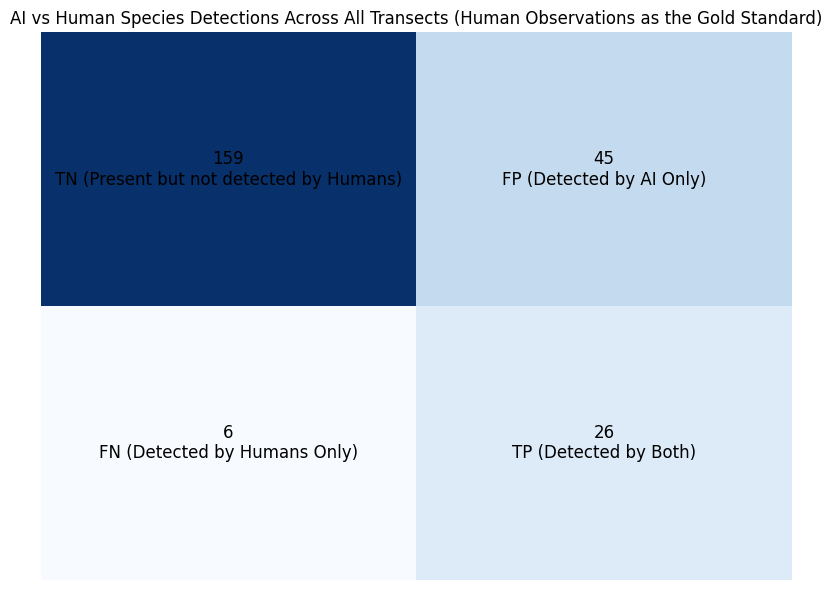

In [53]:
#@title Species Detection Analysis: AI vs Human Species Detections Across All Transects (Human Observations as the Gold Standard)

# Load the updated Excel file with human observations
human_data = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/HAU_Scientific_Final.xlsx')

# Ensure the start_time is parsed correctly in human data
human_data['start_time'] = pd.to_datetime(human_data['start_time'], format='%H:%M:%S')

# Extract the scientific names and observation times from the human observations
human_detections = set(human_data['Scientific_Name'].dropna().unique())

# Determine the earliest and latest start times in human observations
earliest_time = human_data['start_time'].min()
latest_time = human_data['start_time'].max()

# Print the time range
print(f"Earliest human observation time: {earliest_time.time()}")
print(f"Latest human observation time: {latest_time.time()}")

# Load BirdNET predictions with time filtering
def load_birdnet_predictions(file_paths, earliest_time, latest_time):
    species = []
    for path in file_paths:
        df = pd.read_excel(path)
        # Ensure the start_time is parsed correctly in AI data
        df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M:%S')
        # Filter AI predictions to only include those within the human observation time range
        df_filtered = df[(df['start_time'] >= earliest_time) & (df['start_time'] <= latest_time)]
        # Print filtered data to verify
        print(f"Filtered AI predictions from {path}: {df_filtered.shape[0]} records found.")
        species.extend(df_filtered['scientific_name'].tolist())
    return set(species)  # Remove duplicates and convert to set

# Load GBIF data
gbif_data = pd.read_csv('/content/BirdnetProject/Files/data/CSV_data/birds_30kmx30km_10years.csv')
unique_species_gbif = set(gbif_data['scientificName'])  # Adjust to the correct column name

# Print original species counts
print(f"Number of unique species detected by humans: {len(human_detections)}")
print(f"Number of unique species in GBIF data: {len(unique_species_gbif)}")

# Set up the figure for the plot
fig, ax = plt.subplots(figsize=(8, 6), sharex=True, sharey=True)

# Function to visualise confusion matrix
def plot_confusion_matrix(cm, title, ax):
    labels = ['TN (Present but not detected by Humans)', 'FP (Detected by AI Only)',
              'FN (Detected by Humans Only)', 'TP (Detected by Both)']
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.text(0.5, 0.5, f'{cm[0, 0]}\n{labels[0]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(1.5, 0.5, f'{cm[0, 1]}\n{labels[1]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(0.5, 1.5, f'{cm[1, 0]}\n{labels[2]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(1.5, 1.5, f'{cm[1, 1]}\n{labels[3]}', ha='center', va='center', fontsize=12, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

# File paths and titles for visualisation
files = [
    ('/content/BirdnetProject/Files/data/xlsx_data/Bird_Detection_Data.xlsx', "AI vs Human Species Detections Across All Transects (Human Observations as the Gold Standard)")
]

# Generate Confusion Matrix data
for idx, (file_path, title) in enumerate(files):
    # Load BirdNET data with time filter
    predicted_species = load_birdnet_predictions([file_path], earliest_time, latest_time)

    # Print the number of unique species detected by AI after filtering
    print(f"Number of unique species detected by AI: {len(predicted_species)}")

    # Check if there are any AI detections left after filtering
    if not predicted_species:
        print("No AI detections found in the given time range.")
        continue

    # Combine human and predicted species lists
    all_species = list(human_detections.union(predicted_species))

    # Create presence/absence vectors
    human_vector = [1 if species in human_detections else 0 for species in all_species]
    predicted_vector = [1 if species in predicted_species else 0 for species in all_species]

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(human_vector, predicted_vector)

    # Correct TN calculation
    true_negatives_count = len(unique_species_gbif) - len(human_detections)
    conf_matrix[0, 0] = true_negatives_count

    # Plot Confusion Matrix
    plot_confusion_matrix(conf_matrix, title=f'{title}', ax=ax)

    # Generate and print classification report
    report = classification_report(human_vector, predicted_vector, target_names=['Not Detected by AI', 'Detected by AI'])
    print(f"Classification Report for {title}:\n")
    print(report)

plt.tight_layout()
plt.show()

In [49]:
#@title **Step 6: Sensitivity, Specificity, and Detection Percentages**

# Sensitivity and Specificity Calculation
TN, FP, FN, TP = conf_matrix.ravel()

sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

# Print Sensitivity and Specificity
print(f"Sensitivity (True Positive Rate): {sensitivity:.2f}")
print(f"Specificity (True Negative Rate): {specificity:.2f}")

# Calculate total species in GBIF dataset
total_species_gbif = len(unique_species_gbif)

# Calculate species detected by AI
detected_by_ai = len(predicted_species)

# Calculate species detected by humans
detected_by_humans = len(human_detections)

# Calculate species detected by both AI and humans
detected_by_both = len(human_detections.intersection(predicted_species))

# Calculate percentages
percent_detected_by_ai = (detected_by_ai / total_species_gbif) * 100
percent_detected_by_humans = (detected_by_humans / total_species_gbif) * 100
percent_detected_by_both = (detected_by_both / total_species_gbif) * 100

# Print results
print(f"Percentage of total species detected by AI: {percent_detected_by_ai:.2f}%")
print(f"Percentage of total species detected by Humans: {percent_detected_by_humans:.2f}%")
print(f"Percentage of total species detected by both AI and Humans: {percent_detected_by_both:.2f}%")

Sensitivity (True Positive Rate): 0.81
Specificity (True Negative Rate): 0.78
Percentage of total species detected by AI: 37.17%
Percentage of total species detected by Humans: 16.75%
Percentage of total species detected by both AI and Humans: 13.61%


Earliest human observation time: 06:30:00
Latest human observation time: 07:45:00
Number of unique species detected by humans: 32
Number of unique species in GBIF data: 191
Filtered AI predictions from /content/BirdnetProject/Files/data/xlsx_data/Bird_Detection_Data.xlsx: 11018 records found.
Number of unique species detected by AI: 71
Classification Report for Human vs AI Species Detections Across All Transects (AI Detections as the Gold Standard):

                        precision    recall  f1-score   support

Not Detected by Humans       0.00      0.00      0.00         6
    Detected by Humans       0.81      0.37      0.50        71

              accuracy                           0.34        77
             macro avg       0.41      0.18      0.25        77
          weighted avg       0.75      0.34      0.47        77



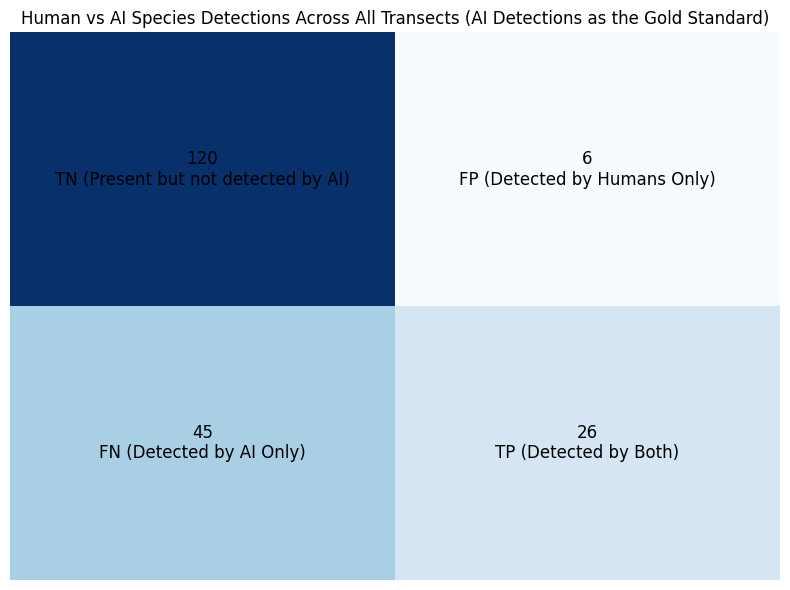

In [54]:
#@title Species Detection Analysis: Human vs AI Species Detections Across All Transects (AI Detections as the Gold Standard)

# Load the updated Excel file with human observations
human_data = pd.read_excel('/content/BirdnetProject/Files/data/xlsx_data/HAU_Scientific_Final.xlsx')

# Ensure the start_time is parsed correctly in human data
human_data['start_time'] = pd.to_datetime(human_data['start_time'], format='%H:%M:%S')

# Extract the scientific names and observation times from the human observations
human_detections = set(human_data['Scientific_Name'].dropna().unique())

# Determine the earliest and latest start times in human observations
earliest_time = human_data['start_time'].min()
latest_time = human_data['start_time'].max()

# Print the time range
print(f"Earliest human observation time: {earliest_time.time()}")
print(f"Latest human observation time: {latest_time.time()}")

# Load BirdNET predictions with time filtering
def load_birdnet_predictions(file_paths, earliest_time, latest_time):
    species = []
    for path in file_paths:
        df = pd.read_excel(path)
        # Ensure the start_time is parsed correctly in AI data
        df['start_time'] = pd.to_datetime(df['start_time'], format='%H:%M:%S')
        # Filter AI predictions to only include those within the human observation time range
        df_filtered = df[(df['start_time'] >= earliest_time) & (df['start_time'] <= latest_time)]
        # Print filtered data to verify
        print(f"Filtered AI predictions from {path}: {df_filtered.shape[0]} records found.")
        species.extend(df_filtered['scientific_name'].tolist())
    return set(species)  # Remove duplicates and convert to set

# Load GBIF data
gbif_data = pd.read_csv('/content/BirdnetProject/Files/data/CSV_data/birds_30kmx30km_10years.csv')
unique_species_gbif = set(gbif_data['scientificName'])  # Adjust to the correct column name

# Print original species counts
print(f"Number of unique species detected by humans: {len(human_detections)}")
print(f"Number of unique species in GBIF data: {len(unique_species_gbif)}")

# Set up the figure for the plot
fig, ax = plt.subplots(figsize=(8, 6), sharex=True, sharey=True)

# Function to visualise confusion matrix
def plot_confusion_matrix(cm, title, ax):
    labels = ['TN (Present but not detected by AI)', 'FP (Detected by Humans Only)',
              'FN (Detected by AI Only)', 'TP (Detected by Both)']
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=ax, cbar=False)
    ax.text(0.5, 0.5, f'{cm[0, 0]}\n{labels[0]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(1.5, 0.5, f'{cm[0, 1]}\n{labels[1]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(0.5, 1.5, f'{cm[1, 0]}\n{labels[2]}', ha='center', va='center', fontsize=12, color='black')
    ax.text(1.5, 1.5, f'{cm[1, 1]}\n{labels[3]}', ha='center', va='center', fontsize=12, color='black')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

# File paths and titles for visualisation
files = [
    ('/content/BirdnetProject/Files/data/xlsx_data/Bird_Detection_Data.xlsx', "Human vs AI Species Detections Across All Transects (AI Detections as the Gold Standard)")
]

# Generate Confusion Matrix data
for idx, (file_path, title) in enumerate(files):
    # Load BirdNET data with time filter
    predicted_species = load_birdnet_predictions([file_path], earliest_time, latest_time)

    # Print the number of unique species detected by AI after filtering
    print(f"Number of unique species detected by AI: {len(predicted_species)}")

    # Check if there are any AI detections left after filtering
    if not predicted_species:
        print("No AI detections found in the given time range.")
        continue

    # Combine human and predicted species lists
    all_species = list(human_detections.union(predicted_species))

    # Create presence/absence vectors
    human_vector = [1 if species in human_detections else 0 for species in all_species]
    predicted_vector = [1 if species in predicted_species else 0 for species in all_species]

    # Generate Confusion Matrix
    conf_matrix = confusion_matrix(predicted_vector, human_vector)  # Reversed vectors for AI as the gold standard

    # Correct TN calculation
    true_negatives_count = len(unique_species_gbif) - len(predicted_species)
    conf_matrix[0, 0] = true_negatives_count

    # Plot Confusion Matrix
    plot_confusion_matrix(conf_matrix, title=f'{title}', ax=ax)

    # Generate and print classification report
    report = classification_report(predicted_vector, human_vector, target_names=['Not Detected by Humans', 'Detected by Humans'])
    print(f"Classification Report for {title}:\n")
    print(report)

plt.tight_layout()
plt.show()